# Bokeh

In this practical we are going to work with bokeh, a library for interactive data visualization
We will also make static versions of the plot for comparison using seaborn

https://bokeh.org/

In [1]:
# make noteobok wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd # data transformation
from datetime import datetime # handle dates
import numpy as np # math

# viz
import pylab as plt # base library
import seaborn as sns # tidy viz
from descartes import PolygonPatch # maps
import geopandas as gp # maps


# change the default colors and behavior of the plot
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False,
                 "lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": False, "xtick.labelcolor": "#484848", 
                 "ytick.labelcolor": "#484848", "xtick.color": "#484848", "ytick.color": "#484848","text.color": "#484848", 
                 "axes.labelcolor": "#484848", "axes.titlecolor":"#484848", "figure.figsize": [5,3],
                 "axes.titlelocation":"left","xaxis.labellocation":"left","yaxis.labellocation":"bottom"}

palette = ["#3d348b","#e6af2e","#191716","#a65628"] #use your favourite colours

sns.set_theme(context='paper', style='white', palette=palette, font='Verdana', font_scale=1.3, color_codes=True, rc=custom_params)

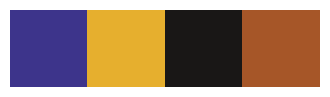

In [2]:
sns.palplot(palette)

In [3]:
# Imports bokeh
from bokeh.io import show, output_notebook, output_file # others: push_notebook
from bokeh.models import ColumnDataSource, LogAxis, HoverTool, RangeTool, LogColorMapper, GeoJSONDataSource, LinearColorMapper, CategoricalColorMapper, Slider
from bokeh.layouts import row, column   # join plots
from bokeh.plotting import figure       # create figure
from bokeh.tile_providers import get_provider, WIKIMEDIA # for maps, others: CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER, ESRI_IMAGERY, OSM
from bokeh.palettes import YlGnBu9 as YlGnBu,  YlOrBr9, YlOrBr4 # palettes

output_notebook() #output to notebook

Loading BokehJS ...

## Read the data

Covid data in Europe

In [4]:
#pandas doesn't detect the format correctly, doing it manually
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')

#read data
df = pd.read_excel("data/data-1.xlsx", parse_dates=["dateRep"], date_parser=parser)
df["cases_capita"] = 1E6*df["cases"]/df["popData2020"]
df["deaths_capita"] = 1E6*df["deaths"]/df["popData2020"]

df = df.loc[df["dateRep"]>"2020-03-01"]

#resample per week
df = df.groupby(["countriesAndTerritories","geoId"]).resample("M", on='dateRep').mean(numeric_only=True).reset_index()

#print head
df.head()

,countriesAndTerritories,geoId,dateRep,year,month,day,cases,deaths,popData2020,cases_capita,deaths_capita
0,Austria,AT,2020-03-31,2020.0,3.0,16.5,349.200000,5.766667,8901064.0,39.231265,0.647863
1,Austria,AT,2020-04-30,2020.0,4.0,15.5,167.700000,15.433333,8901064.0,18.840444,1.733875
2,Austria,AT,2020-05-31,2020.0,5.0,16.0,36.451613,1.935484,8901064.0,4.095197,0.217444
3,Austria,AT,2020-06-30,2020.0,6.0,15.5,37.766667,1.266667,8901064.0,4.242938,0.142305
4,Austria,AT,2020-07-31,2020.0,7.0,16.0,109.903226,0.451613,8901064.0,12.347201,0.050737


## First plot: Scatter cases

Plot the number of cases (per 1M people) vs number of deaths (per 1M). 

For clarity let's use only four countries: NL, ES, FR, BE

In [5]:
df_subset = df.loc[df["geoId"].isin({"NL", "ES", "FR", "BE"})]

### Static example

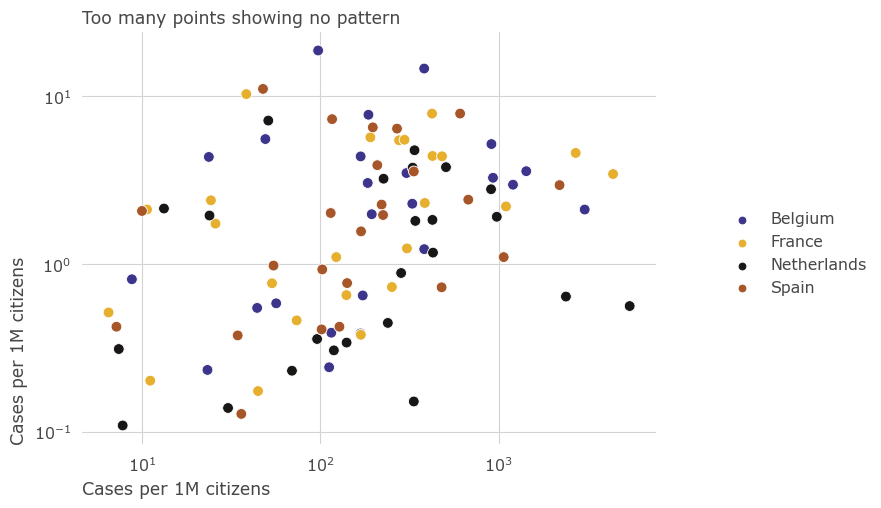

In [6]:
g = sns.relplot(x="cases_capita", # x channel
                y="deaths_capita",  # y channel
                hue="countriesAndTerritories",  # color
                kind="scatter",  # type of plot (scatter / line)
                data=df_subset, # data
                aspect=1.4,
                s=60) # make it a bit wider 

#log scale
plt.xscale("log")
plt.yscale("log")

#add gridlines, remove axes lines
plt.grid()
sns.despine(left=True, bottom=True)

#labels
plt.xlabel("Cases per 1M citizens")
plt.ylabel("Cases per 1M citizens")

#title
plt.title("Too many points showing no pattern")
#remove legend title
g.legend.set_title("")

plt.show()

### Dynamic example

In [7]:
##Basic example

p = figure(plot_width=600, 
           plot_height=450, 
           title = "Too many points for a plot", 
           y_axis_type="log",  
           x_axis_type="log",
           x_axis_label = 'Cases per capita',
           y_axis_label = 'Deaths per capita',
           toolbar_location="right",
           toolbar_sticky=False)

# Adding each country separately so we can click on the legend
i = 0
for country, data in df_subset.groupby("countriesAndTerritories"): 
    p.scatter('cases_capita', 'deaths_capita', source=data, fill_alpha=0.6, size=10, legend_group="countriesAndTerritories", color=palette[i])
    i +=1 
    
# p.xaxis.
p.legend.location = "top_left"
p.yaxis.axis_line_color = None
p.xaxis.axis_line_color = None

show(p)

In [8]:
##Addign tooltips
tooltips=[
    ( 'Country','@countriesAndTerritories'),
    ( 'Date',   '@dateRep'                ),
    ( 'Cases',  '@cases_capita{0.2f}'     ), # use @{ } for field names with spaces
    ( 'Deaths', '@deaths_capita{0.2f}'    ),
]
    
    

p = figure(plot_width=600, 
           plot_height=450, 
           title = "Too many points for a plot", 
           y_axis_type="log",  
           x_axis_type="log",
           x_axis_label = 'Cases per capita',
           y_axis_label = 'Deaths per capita',
           toolbar_location="below",
           toolbar_sticky=False,
           tooltips=tooltips)

i = 0
for country, data in df_subset.groupby("countriesAndTerritories"): 
    p.scatter('cases_capita', 'deaths_capita', source=data, fill_alpha=0.6, size=10, legend_group="countriesAndTerritories", color=palette[i])
    i +=1 
    
p.legend.location = "top_left"
p.legend.click_policy="mute"



show(p)



In [9]:
##Addign tooltips with right date
p = figure(plot_width=600, 
           plot_height=450, 
           title = "Too many points for a plot", 
           y_axis_type="log",  
           x_axis_type="log",
           x_axis_label = 'Cases per capita',
           y_axis_label = 'Deaths per capita',
           toolbar_location="below",
           toolbar_sticky=False)
#          tools="hover")#, tooltips="@countriesAndTerritories: (@dateRep, @cases_capita, @deaths_capita)")


i = 0
for country, data in df_subset.groupby("countriesAndTerritories"): 
    p.scatter('cases_capita', 'deaths_capita', source=data, 
              fill_alpha=0.6, size=10, legend_group="countriesAndTerritories", color=palette[i])
    i +=1 

# Add axex
p.legend.location = "top_left"
p.legend.click_policy="mute"


# Add hover tool
hover = HoverTool(
    tooltips=[
        ( 'Country', '@countriesAndTerritories'            ),
        ( 'Date',   '@dateRep{%F}'            ),
        ( 'Cases',  '@cases_capita{0.2f}' ), # use @{ } for field names with spaces
        ( 'Deaths', '@deaths_capita{0.2f}'      ),
    ],

    formatters={
        '@dateRep'     : 'datetime', # use 'datetime' formatter for '@date' field
        '@{adj close}' : 'printf',   # use 'printf' formatter for '@{adj close}' field
                                     # use default 'numeral' formatter for other fields
    },

)
p.add_tools(hover)

show(p)



## Second  plot: Line

Basic plot just changes scatter with line and x_axis_type

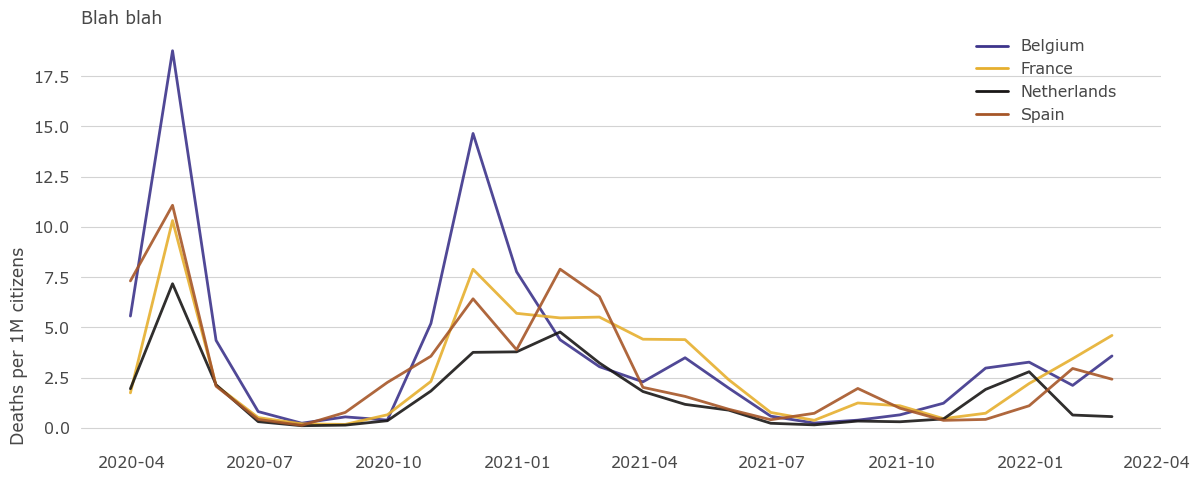

In [10]:
g = sns.relplot(x="dateRep", # x channel
            y="deaths_capita",  # y channel
            hue="countriesAndTerritories",  # color
            kind="line",  # type of plot (scatter / line)
            data=df_subset, # data
            aspect=2.4,
            alpha=0.9) # make it a bit wider 

#add gridlines, remove axes lines
plt.gca().grid(axis="y")
sns.despine(left=True, bottom=True)

#labels
plt.xlabel("")
plt.ylabel("Deaths per 1M citizens")

#title
plt.title("Blah blah")
#remove legend title
g.legend.set_title("")


g.legend.set_bbox_to_anchor([0.8, 0.8])  # coordinates of lower left of bounding box
# g.legend._loc = 3  # if required you can set the loc
plt.show()

In [11]:
p = figure(plot_width=900, 
           plot_height=450, 
           title = "Belgium was especially affected by covid", 
           y_axis_type="linear",  
           x_axis_type="datetime",
           x_axis_label = '',
           y_axis_label = 'Deaths per capita',
           toolbar_location="below",
           toolbar_sticky=False,
           tools="xpan", 
           x_range=(df_subset.dateRep.min(), df_subset.dateRep.max()),)
#          tools="hover")#, tooltips="@countriesAndTerritories: (@dateRep, @cases_capita, @deaths_capita)")

i = 0
for country, data in df_subset.groupby("countriesAndTerritories"): 
    p.line('dateRep', 'deaths_capita', source=data, line_alpha=0.6,l ine_width=3, legend_group="countriesAndTerritories", color=palette[i])
    i +=1 
    

p.legend.location = "top_left"
p.legend.click_policy="mute"



hover = HoverTool(
    tooltips=[
        ( 'Country',   '@countriesAndTerritories'            ),
        ( 'Date',   '@dateRep{%F}'            ),
        ( 'Cases',  '@cases_capita{0.2f}' ), # use @{ } for field names with spaces
        ( 'Deaths', '@deaths_capita{0.2f}'      ),
    ],

    formatters={
        '@dateRep'        : 'datetime', # use 'datetime' formatter for '@date' field
        '@{adj close}' : 'printf',   # use 'printf' formatter for '@{adj close}' field
                                     # use default 'numeral' formatter for other fields
    },

    # display a tooltip whenever the cursor is vertically in line with a glyph
#    mode='vline'
)
p.add_tools(hover)
show(p)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1075305243.py, line 16)

In [ ]:
p = figure(plot_width=900, 
           plot_height=450, 
           title = "Belgium was especially affected by covid", 
           y_axis_type="linear",  
           x_axis_type="datetime",
           x_axis_label = '',
           y_axis_label = 'Deaths per capita',
           toolbar_location="below",
           toolbar_sticky=False, 
           x_range=(df_subset.dateRep.min(), df_subset.dateRep.max()))
#          tools="hover")#, tooltips="@countriesAndTerritories: (@dateRep, @cases_capita, @deaths_capita)")

i = 0
for country, data in df_subset.groupby("countriesAndTerritories"): 
    p.line('dateRep','deaths_capita',source=data,line_alpha=0.6,line_width=3, legend_group="countriesAndTerritories", color=palette[i])
    p.scatter('dateRep','deaths_capita',source=data,  color=palette[i])

    i +=1 
    

p.legend.location = "top_left"
p.legend.click_policy="mute"


hover = HoverTool(
    tooltips=[
        ( 'Country',   '@countriesAndTerritories'            ),
        ( 'Date',   '@dateRep{%F}'            ),
        ( 'Cases',  '@cases_capita{0.2f}' ), # use @{ } for field names with spaces
        ( 'Deaths', '@deaths_capita{0.2f}'      ),
    ],

    formatters={
        '@dateRep'        : 'datetime', # use 'datetime' formatter for '@date' field
        '@{adj close}' : 'printf',   # use 'printf' formatter for '@{adj close}' field
                                     # use default 'numeral' formatter for other fields
    },

    # display a tooltip whenever the cursor is vertically in line with a glyph
#    mode='vline'
)
p.add_tools(hover)

# new figure with the rangetool
select = figure(title="Drag the middle and edges of the selection box to change the range above",
                height=130, width=900, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="whitesmoke")

# join the x_ranges
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "cornflowerblue"
range_tool.overlay.fill_alpha = 0.2

select.line('dateRep', 'deaths_capita', source=df_subset, color="gray")
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

# stack figures
show(column(p, select))



## Plot 3: cloropleth

In [ ]:
df_av = df.groupby("geoId").mean()

In [ ]:
# Plot EU
df_g = gp.read_file("data/CNTR_RG_60M_2020_4326.shp.zip")#, SHAPE_RESTORE_SHX)
df_g = df_g.loc[df_g["EU_STAT"]=="T"]
df_g = pd.merge(df_g, df_av, left_on="FID",right_on="geoId", how="left")

import copy
def largest_area_only(geoms):
    if geoms.geometryType() != "MultiPolygon":
        return geoms
    else:
        max_area = -1
        for geom in geoms.geoms:
            
#             print(geom.area, max_area, geom.area>max_area)
            if geom.area > max_area:
                max_area = geom.area
                ret_area = geom
                
#             print(geom.area, max_area)
#             display(geom)
#         print(max_area)
        return ret_area

    
    
df_g["geometry"] = df_g["geometry"].apply(largest_area_only)

# equirectangular
df_g = df_g.to_crs({'init': 'epsg:4326'}) 


In [ ]:
#Make the plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.set_aspect("equal") #this one is important
g = df_g.plot(linewidth=0.1,cmap=plt.get_cmap("YlOrBr",4), column="deaths_capita", ax=ax, legend=True, 
              vmin=0, vmax=8, legend_kwds={'label': 'Deaths covid', 'ticks': np.arange(0, 8, 2)})
plt.axis('off')
plt.show()

In [ ]:
# Just to use exactly the same colors
cmap = plt.get_cmap("YlOrBr", 4)
from matplotlib.colors import rgb2hex
cmap = [rgb2hex(cmap(_)) for _ in range(4)]

In [ ]:
fig = figure(plot_width=450, 
             plot_height=550,
             title="United States Population Per State [2018] Choropleth Map",
             x_axis_location=None, y_axis_location=None,
             tooltips=[
                        ("Name", "@NAME_ENGL"), ("Deaths", "@deaths_capita")
                      ],
             x_axis_type="mercator", 
             y_axis_type="mercator",
             tools="hover")

fig.grid.grid_line_color = None
geo_source = GeoJSONDataSource(geojson=df_g.to_json())
color_mapper = LinearColorMapper(palette=cmap, low=0, high=8)
fig.patches("xs", "ys", source=geo_source,
            fill_color={'field': 'deaths_capita', 'transform': color_mapper},
            line_color="white", line_width=0.5)


# You could also add a map on top (WIKIMEDIA/OMS/etc)
# wikimedia = get_provider(WIKIMEDIA)
# fig.add_tile(wikimedia)

show(fig)

## Part 4: Linking plots


https://docs.bokeh.org/en/latest/docs/user_guide/interaction/linking.html

In [ ]:
link_fig = show(row(column(p, select), fig))

In [ ]:
#output_file("bokeh_output.html", title="Nice plot")  # save in this file

#from bokeh.io.export import export_svg
#export_svg(link_fig, filename="plot.svg")

# B: Create entire apps

Using only JS
- Requires knowledge of JS
- No need for a server
- https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Using a server
- Using your computer as a server (locally) --> Fine
- Deploying online --> Seems complicated
- Using juypter notebook as a server --> Fine (example below, from https://github.com/bokeh/bokeh/blob/2.4.3/examples/howto/server_embed/notebook_embed.ipynb)


In [ ]:
from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

In [ ]:
def bkapp(doc):
    # read data and convert it to bokeh's data structure
    df = sea_surface_temperature.copy()
    source = ColumnDataSource(data=df)

    # make plot
    plot = figure(plot_width=650, 
                  plot_height=450,
                  x_axis_type='datetime', y_range=(0, 25),
                  y_axis_label='Temperature (Celsius)',
                  title="Sea Surface Temperature at 43.18, -70.43")
    # add line
    plot.line('time', 'temperature', source=source)

    # callback for reactivity
    def callback(attr, old, new):
        if new == 0:
            data = df
        else:
            data = df.rolling('{0}D'.format(new)).mean()
        source.data = ColumnDataSource.from_df(data)

    # somethign to interact with
    slider = Slider(start=0, end=30, value=0, step=1, title="Smoothing by N Days")
    slider.on_change('value', callback) # when to use callback

    # update plot
    doc.add_root(column(slider, plot))


## Create a standalone app using panel
# https://panel.holoviz.org/user_guide/Running_in_Webassembly.html
# remove the parameter of the function and return the plot: return column(slider, plot)
# call the app as: bokeh_app = pn.pane.Bokeh(bkapp()).servable()

## Convert to standalone app
# panel convert bokeh_app.py --to pyodide-worker --out ./app --pwa 

## Check locally (or upload to e.g. github)
# python3 -m http.server
# bokeh_app = pn.pane.Bokeh(column(slider, plot)).servable()


In [ ]:
show(bkapp) # notebook_url="http://localhost:8888" 
